In [1]:
using DrWatson
@quickactivate "Research"

In [63]:
using LinearAlgebra, Statistics, Distances, VecTarget, CoupledHMC
using CoupledHMC: AdvancedHMC
using Plots, LaTeXStrings

dim = 2
target = get_target(HighDimGaussian(dim))
q₀ = [
    -2.0 1.0;
     0.0 0.5
]
metric = AdvancedHMC.UnitEuclideanMetric((dim, 2))
hamiltonian = AdvancedHMC.Hamiltonian(metric, target.logdensity, target.get_grad(q₀))
integrator = AdvancedHMC.Leapfrog(fill(0.3, 2))

p₀ = [-1, 1]
z = AdvancedHMC.phasepoint(hamiltonian, q₀, cat(p₀, p₀; dims=2))
zs = [z, AdvancedHMC.step(integrator, hamiltonian, z, 7; fwd=true, full_trajectory=Val(true))...]

ℓweights = -AdvancedHMC.energy.(zs)
ℓweights = cat(ℓweights...; dims=2)
unnorm_ℓprob = ℓweights
prob = exp.(unnorm_ℓprob .- AdvancedHMC.logsumexp(unnorm_ℓprob; dims=2))

τ¹ = cat(map(z -> z.θ[:,1], zs)...; dims=2)
τ² = cat(map(z -> z.θ[:,2], zs)...; dims=2)
p, q = prob[1,:], prob[2,:]

# Here's a hand-crafted toy example - comment it out to try!
# τ¹ = reshape([100, 74, 94, 19, 73], 1, :)
# τ² = reshape([ 74, 83, 35, 66, 57], 1, :)
# p = [0.15, 0.42, 0.14, 0.21, 0.08]
# q = [0.52, 0.12, 0.18, 0.16, 0.02]

([0.12409928298326267, 0.12274674996496591, 0.12235036273269724, 0.12304086582735274, 0.12458973696573176, 0.1264713336584791, 0.1280230170062869, 0.1286786508612237], [0.12546722946599762, 0.1257731488246476, 0.12577347553212598, 0.12546809251759505, 0.12496608334910153, 0.12444525936666462, 0.12408810954710119, 0.12401860139676675])

┌ Warning: Skipped xaxis arg equal
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/shY1Z/src/axes.jl:73
┌ Warning: Skipped yaxis arg equal
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/shY1Z/src/axes.jl:73
┌ Warning: Skipped zaxis arg equal
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/shY1Z/src/axes.jl:73


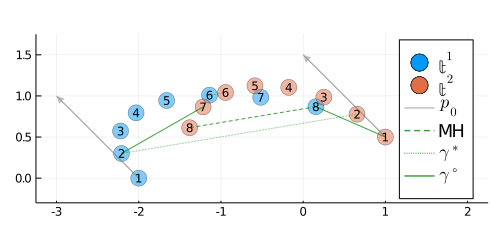

In [86]:
function vis_τ(τ¹, τ², p₀; figsize=(500, 250), do_annotation=false)
    fig = plot(theme=:bright, size=figsize, aspect_ratio=1, legendmarkersize=1, legendfontsize=12, axis=:equal)
    xlims!(-3.25, 2.25)
    ylims!(-0.30, 1.75)
    scatter!(fig, τ¹[1,:], τ¹[2,:]; label=L"\mathbb{t}^1", alpha=0.5, markersize=9)
    scatter!(fig, τ²[1,:], τ²[2,:]; label=L"\mathbb{t}^2", alpha=0.5, markersize=9)
    plot!(
        fig, [τ¹[1,1], τ¹[1,1] + p₀[1]], [τ¹[2,1], τ¹[2,1] + p₀[2]]; 
        label=L"p_0", arrow=arrow(:closed), alpha=0.5, c=:gray
    )
    plot!(
        fig, [τ²[1,1], τ²[1,1] + p₀[1]], [τ²[2,1], τ²[2,1] + p₀[2]]; 
        label=nothing, arrow=arrow(:closed), alpha=0.5, c=:gray
    )
    annotate!([(τ¹[1,i], τ¹[2,i], Plots.text("$i", 8, :black, :center)) for i in 1:size(τ¹, 2)])
    annotate!([(τ²[1,i], τ²[2,i], Plots.text("$i", 8, :black, :center)) for i in 1:size(τ², 2)])
    if do_annotation
        plot!(
            fig, [τ¹[1,end], τ²[1,end]], [τ¹[2,end], τ²[2,end]]; label="MH", alpha=0.75, style=:dash, c=:green
        )
        plot!(
            fig, [τ¹[1,2], τ²[1,2]], [τ¹[2,2], τ²[2,2]]; label=nothing, alpha=0.75, style=:dot, c=:green
        )
        plot!(
            fig, [τ¹[1,6], τ²[1,6]], [τ¹[2,6], τ²[2,6]]; label=L"\gamma^\ast", alpha=0.75, style=:dot, c=:green
        )
        plot!(
            fig, [τ¹[1,2], τ²[1,end-1]], [τ¹[2,2], τ²[2,end-1]]; label=nothing, alpha=0.75, style=:solid, c=:green
        )
        plot!(
            fig, [τ¹[1,end], τ²[1,1]], [τ¹[2,end], τ²[2,1]]; label=L"\gamma^\circ", alpha=0.75, style=:solid, c=:green
        )
    end
    fig
end

fig_τ = vis_τ(τ¹, τ², p₀; do_annotation=true)

savefig(fig_τ, plotsdir("illustration", "trajectories.png"))
savefig(fig_τ, plotsdir("illustration", "trajectories.pdf"))

fig_τ

In [55]:
Base.count(idcs, K::Int) = [count(idx -> idx == k, idcs) for k in 1:K]

expdistance_of(samples) = mean(s -> norm(s.x - s.y), samples)

W2_of(samples) = sqrt(mean(s -> norm(s.x - s.y).^2, samples))

function stats_of(idxpair, p, q, τ¹, τ²)
    M, N = length(p), length(q)
    count_i = count(map(ip -> ip.i, idxpair), M)
    p̂ = count_i / length(idxpair)
    count_j = count(map(ip -> ip.j, idxpair), N)
    q̂ = count_j / length(idxpair)
    samples = map(ip -> (x = τ¹[:,ip.i], y = τ²[:,ip.j]), idxpair)
    return (
        p̂ = round.(p̂; digits=2),
        q̂ = round.(q̂; digits=2),
        kl_p = kl_divergence(p, p̂),
        kl_q = kl_divergence(q, q̂),
        W1 = expdistance_of(samples),
        W2 = W2_of(samples),
    )
end

ic = IndependentCoupling(p, q)
@time idxpair_ic = [rand(ic) for _ in 1:100_000]

@info "Independent Coupling" stats_of(idxpair_ic, p, q, τ¹, τ²)...

  0.326368 seconds (603.45 k allocations: 47.465 MiB, 13.01% gc time)


┌ Info: Independent Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.13, 0.13, 0.12, 0.13, 0.13, 0.13, 0.12, 0.12]
│   kl_p = 3.5564477099861625e-5
│   kl_q = 3.730994729123386e-5
│   W1 = 1.4568417908425495
│   W2 = 1.696037239184829
└ @ Main In[55]:27


In [56]:
qc = QuantileCoupling(p, q)
@time idxpair_qc = [rand(qc) for _ in 1:100_000]

@info "Quantile Coupling" stats_of(idxpair_qc, p, q, τ¹, τ²)...

  0.140364 seconds (634.47 k allocations: 45.243 MiB)


┌ Info: Quantile Coupling
│   p̂ = [0.13, 0.12, 0.12, 0.12, 0.13, 0.12, 0.13, 0.13]
│   q̂ = [0.13, 0.13, 0.12, 0.12, 0.13, 0.12, 0.12, 0.12]
│   kl_p = 7.45307075486764e-5
│   kl_q = 0.00010198284321839531
│   W1 = 1.7414882883739786
│   W2 = 1.9937889017417658
└ @ Main In[56]:4


In [57]:
mc = MaximalCoupling(p, q)
@time idxpair_mc = [rand(mc) for _ in 1:100_000]

@info "Maximal Coupling" stats_of(idxpair_mc, p, q, τ¹, τ²)...

  0.367787 seconds (856.21 k allocations: 68.964 MiB)


┌ Info: Maximal Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13]
│   q̂ = [0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.12]
│   kl_p = 6.019259739152192e-5
│   kl_q = 6.577465933188108e-5
│   W1 = 1.7156117258800267
│   W2 = 1.9724251799634862
└ @ Main In[57]:4


In [58]:
otc = OTCoupling(p, q, τ¹, τ²)
@time idxpair_otc = [rand(otc) for _ in 1:100_000]

@info "OT Coupling" stats_of(idxpair_otc, p, q, τ¹, τ²)...

224.985148 seconds (1.30 G allocations: 71.909 GiB, 8.30% gc time)


┌ Info: OT Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.13, 0.13, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12]
│   kl_p = 1.8393457763750122e-5
│   kl_q = 1.919088000876788e-5
│   W1 = 1.2205650606268654
│   W2 = 1.2423192364862166
└ @ Main In[58]:4


In [24]:
 using CoupledHMC: euclidsq
import CoupledHMC: ApproximateOTCoupling

function ApproximateOTCoupling(
    p::T1, q::T1, τ¹::T2, τ²::T2; reps::T3=1e-2
) where {T1<:AbstractVector, T2<:AbstractVecOrMat, T3<:AbstractFloat}
    D = euclidsq(τ¹, τ²)
    D = D / maximum(D)
    d = size(τ¹, 1)
    eps = sqrt(1 / 2 * median(D) / log(d + 1)) * reps
    return ApproximateOTCoupling(p, q, D, eps)
end

aotc = ApproximateOTCoupling(p, q, τ¹, τ²; eps=1e-2)
@time idxpair_aotc = [rand(aotc) for _ in 1:100_000]

@info "Approximate OT Coupling" stats_of(idxpair_aotc, p, q, τ¹, τ²)...

 25.654580 seconds (3.47 M allocations: 473.438 MiB, 1.20% gc time)


┌ Info: Approximate OT Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.12, 0.13, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12]
│   kl_p = 2.6268322861931282e-5
│   kl_q = 1.8269753964496533e-5
│   W1 = 1.3236899639550357
│   W2 = 1.3766172817008453
└ @ Main In[24]:4


In [92]:
using Printf

function _str(p)
    return @sprintf("%.3f", p)[2:end]
end

_str(0.133333)

".133"

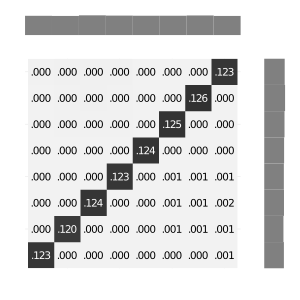

In [95]:
function jointmat_by(idxpair, M, N)
    J = zeros(Int, M, N)
    for ip in idxpair
        J[ip.i,ip.j] += 1
    end
    return J / sum(J)
end

function vis_γ(idxpair, p, q; rescale=1, size=(300, 300), showlabel=false)    
    M, N = length(p), length(p)
    J = jointmat_by(idxpair, M, N)
    @assert (1 / rescale) < (1 / maximum(J)) "Cannot rescale to hide historgram."
    J = J / rescale
    p̂, q̂ = vec(sum(J; dims=2)), vec(sum(J; dims=1))
    
    layout = @layout [
        tophist           _
        hist2d{0.9w,0.9h} righthist
    ]
    fig = plot(; size=size, layout=layout)
    kwlabels = showlabel ? (xlabel = L"\mathbf{q}", ylabel = L"\mathbf{p}") : ()
    heatmap!(
        fig, 1:M, 1:N, 1 .- J; 
        showaxis=false, aspect_ratio=1, clims=(0, 1), colorbar=nothing, subplot=2, c=:grays,
        kwlabels...
    )
    J = J * rescale
    annotate!([[(i, j, Plots.text(_str(J[i,j]), 7, J[i,j] > 0.05 ? :white : :black, :center)) for i in 1:M, j in 1:N]...], subplot=2)
    bar!(
        fig, q̂; 
        bar_width=1, xlims=(0.5, M + 0.5), ylims=(0, 1), c=:gray, linewidth=0,
        showaxis=false, ticks=nothing, legend=nothing, subplot=1
    )
    bar!(
        fig, p̂; 
        bar_width=1, xlims=(0, 1), ylims=(0.5, N + 0.5), c=:gray, linewidth=0,
        showaxis=false, ticks=nothing, legend=nothing, subplot=3, orientation=:h
    )
    return fig
end

ips = [
#     idxpair_qc, 
    idxpair_mc, 
    idxpair_otc, 
#     idxpair_aotc
]
fns = [
#     "quantile_coupling", 
    "maximal_coupling", 
    "ot_coupling", 
#     "approximate_ot_coupling"
]

figs = map(zip(ips, fns)) do (ip, fn)
    fig = vis_γ(ip, p, q; rescale=0.15)
    savefig(fig, plotsdir("illustration", "$fn.png"))
    savefig(fig, plotsdir("illustration", "$fn.pdf"))
    fig
end

In [ ]:
layout = @layout [
    a{0.25w} [b c
              d e]
]

plot(fig_τ, figs...; size=(2 * 500, 500), layout=layout)